In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import torch

import meshio
import trimesh
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
pprint(ds)

ShapeNetDataset()
├── root:       PosixPath('../../data/ShapeNetSem')
├── metadata:   DataFrame(shape=(12288, 16))
|   ├── 'fullId':          Series(len=12288, dtype=object)
|   ├── 'category':        Series(len=12288, dtype=object)
|   ├── 'wnsynset':        Series(len=12288, dtype=object)
|   ├── 'wnlemmas':        Series(len=12288, dtype=object)
|   ├── 'up':              Series(len=12288, dtype=object)
|   ├── 'front':           Series(len=12288, dtype=object)
|   ├── 'unit':            Series(len=12288, dtype=float64)
|   ├── 'aligned.dims':    Series(len=12288, dtype=object)
|   ├── 'isContainerLike': Series(len=12288, dtype=float64)
|   ├── 'surfaceVolume':   Series(len=12288, dtype=float64)
|   └── <6 more items>
├── categories: DataFrame(shape=(283, 5))
|   ├── 'category':     Series(len=283, dtype=object)
|   ├── 'matchLevel':   Series(len=283, dtype=int64)
|   ├── 'synset':       Series(len=283, dtype=object)
|   ├── 'synset words': Series(len=283, dtype=object)
|   └── 'syn

In [4]:
%autoreload
examples = list(ds.examples(variant='TEST'))
pprint(examples, 0)

list(len=12288)


In [5]:
%autoreload
ex = examples[2]
pprint(ex, 2)

Example()
├── dataset:      'ShapeNet'
├── subject:      'wss.101354f9d8dede686f7b08d9de913afe'
├── variant:      'TEST'
├── visit:        None
├── fixed_state:  None
├── moving_state: None
├── paths:        dict(len=12)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/101354f9d8dede686f7b08d9de913afe.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/TEST/10

# Visualize object mesh

Loading ../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj


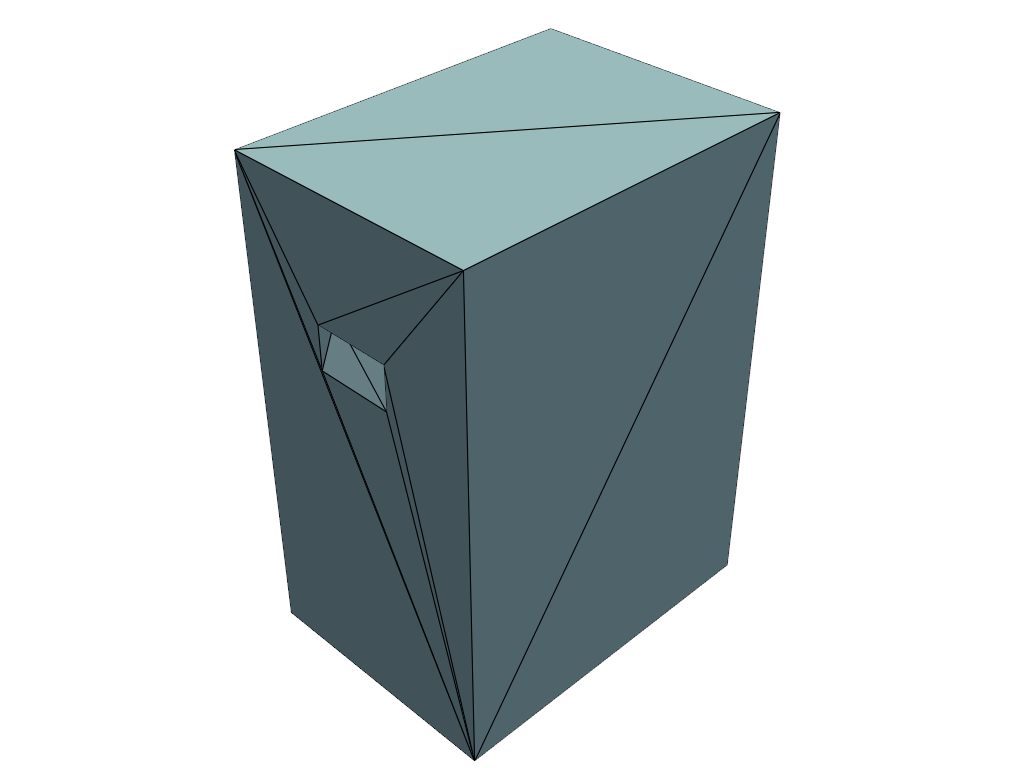

In [26]:
%autoreload
import project.visual.pyvista as pv

raw_mesh = project.core.fileio.load_meshio(ex.paths['source_mesh'])

p = pv.plot_mesh(raw_mesh, show_edges=True)
p.show(jupyter_backend='static')

# Preprocess binary mask

In [27]:
%autoreload
project.preprocessing.api.preprocess_binary_mask(
    mask_path=ex.paths['source_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['binary_mask']
)

Loading ../../data/ShapeNetSem/models-binvox-solid/101354f9d8dede686f7b08d9de913afe.binvox
Loading ../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj
Inferring affine from mesh bounding box
Binvox shape:     [128 128 128]
Binvox translate: [-0.        0.393701 -0.      ]
Binvox scale:     0.0224779
Points bbox min:    [ 0.       -0.393701  0.      ]
Points bbox extent: [31.8898   23.622001 44.4882  ]
(-1, -1)
[[ 0.34756361  0.          0.          0.1737818 ]
 [ 0.          0.34756361  0.         -0.2199192 ]
 [ 0.          0.          0.34756361  0.1737818 ]
 [ 0.          0.          0.          1.        ]]
Cleaning up binary mask
Filtering foreground
Input 1-connected components: 4
  Voxel counts:   [780380      1      1      1] 780383
Output 1-connected components: 1
  Voxels dropped: 3 (0.0004%)
Filtering background
Input 1-connected components: 15
  Voxel counts:   [1312852    3823      83       3       1       1       1       1       1
       1       

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/binary.nii.gz


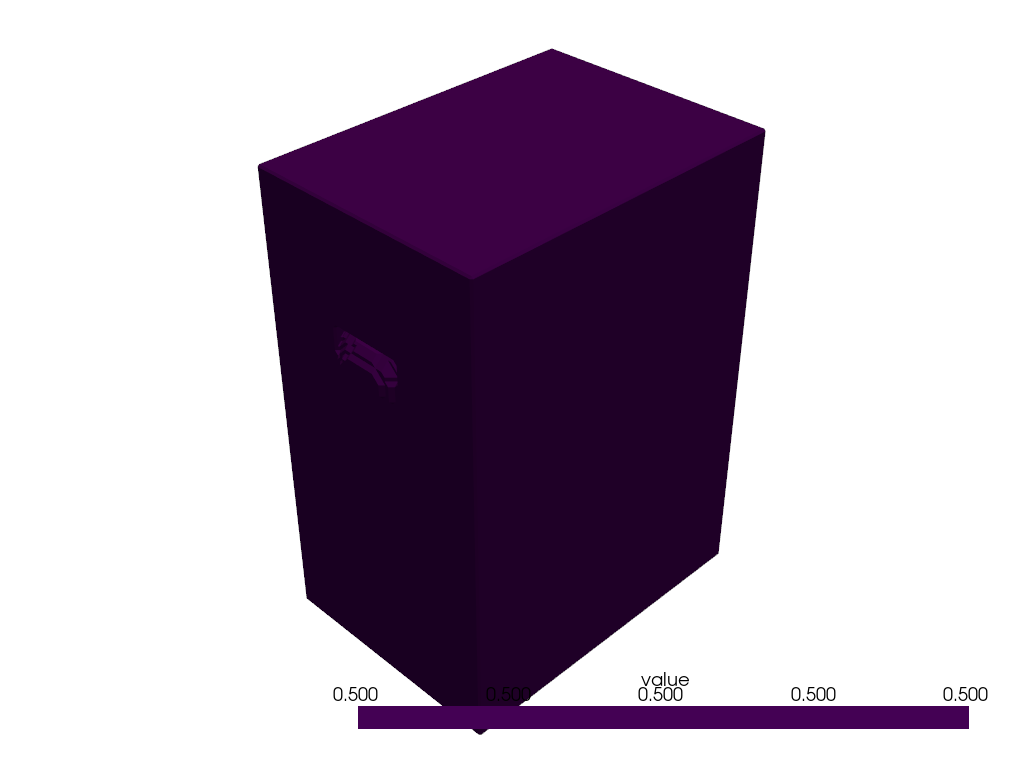

In [28]:
nifti = project.core.fileio.load_nibabel(ex.paths['binary_mask'])
bin_mask, affine = nifti.get_fdata(), nifti.affine

padded_mask, padded_affine = project.preprocessing.affine_fitting.pad_array_and_affine(bin_mask, affine, pad=8)

p = project.visual.pyvista.plot_contour(padded_mask, level=0.5, color='lightblue')
p = project.visual.pyvista.plot_mesh(raw_mesh, style='wireframe', color='black', plotter=p)
p.show(jupyter_backend='static')

# Preprocess surface mesh

In [29]:
project.preprocessing.api.preprocess_surface_mesh(
    input_path=ex.paths['source_mesh'],
    output_path=ex.paths['surface_mesh']
)

Loading ../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj
Repairing surface mesh
Initial mesh state:
dict(len=7)
├── 'vertices':     3372
├── 'faces':        1124
├── 'edges':        dict(len=3)
|   ├── 'boundary':    3372
|   ├── 'interior':    0
|   └── 'nonmanifold': 0
├── 'euler_number': 1124
├── 'watertight':   False
├── 'components':   1124
└── 'angles':       dict(len=5)
    ├── 'min': 2.1721067939229608e-05
    ├── 'p05': 2.4826051660825077
    ├── 'p50': 73.4018487958215
    ├── 'p95': 146.24747013993058
    └── 'max': 179.99995146989576

After trimesh repair:
dict(len=7)
├── 'vertices':     292
├── 'faces':        562
├── 'edges':        dict(len=3)
|   ├── 'boundary':    48
|   ├── 'interior':    771
|   └── 'nonmanifold': 32
├── 'euler_number': 3
├── 'watertight':   False
├── 'components':   7
└── 'angles':       dict(len=5)
    ├── 'min': 2.1721067939229608e-05
    ├── 'p05': 2.5554642226405067
    ├── 'p50': 73.4018487958215
    ├── 'p95': 146.

WARNING- Some cuts were necessary to cope with non manifold configuration.


Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/surface.xdmf


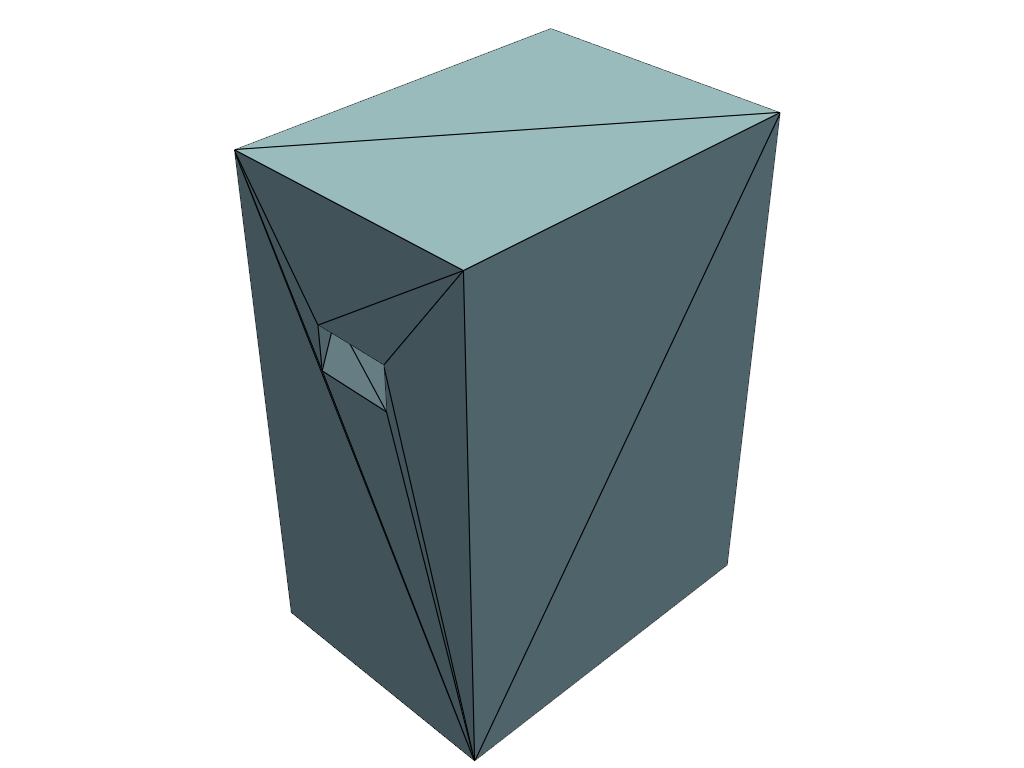

In [30]:
tri_mesh = project.core.fileio.load_meshio(ex.paths['surface_mesh'])

p = project.visual.pyvista.plot_mesh(tri_mesh, show_edges=True)
p.show(jupyter_backend='static')

# Assign region labels

In [32]:
project.preprocessing.api.create_mesh_region_mask(
    mask_path=ex.paths['binary_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['region_mask']
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/binary.nii.gz
Loading ../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj
Extracting labels from mesh
Assigning labels to voxels
100%|██████████| 79/79 [01:21<00:00,  1.03s/it]
Cleaning up region mask
Filtering region 1
Input 1-connected components: 78
  Voxel counts:   [19 19 17 17 14 12 11 10 10 10  9  8  8  8  7  6  5  5  4  4  4  4  4  4
  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1] 295
Output 1-connected components: 0
  Voxels dropped: 295 (100.0000%)
Filtering region 2
Input 1-connected components: 3
  Voxel counts:   [421450      1      1] 421452
Output 1-connected components: 1
  Voxels dropped: 2 (0.0005%)
Filtering region 3
Input 1-connected components: 139
  Voxel counts:   [1279 1138  233  134   24   23   22   21   21   19   17   17   15   14
   13   11   1

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz


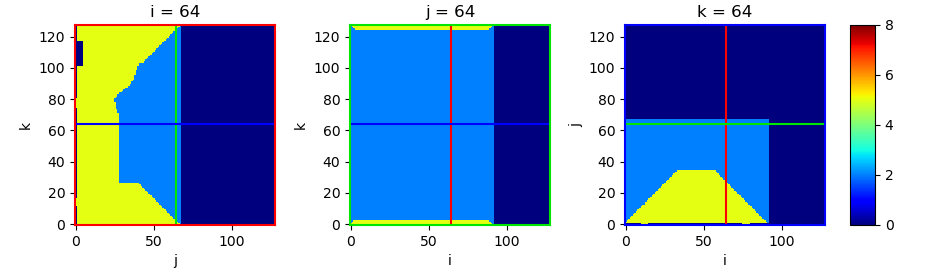

In [33]:
%autoreload
nifti = project.core.fileio.load_nibabel(ex.paths['region_mask'])
region_mask = nifti.get_fdata().astype(int)

fig = project.visual.matplotlib.show_image_slices(region_mask, cmap='jet', clim=(0, 8))

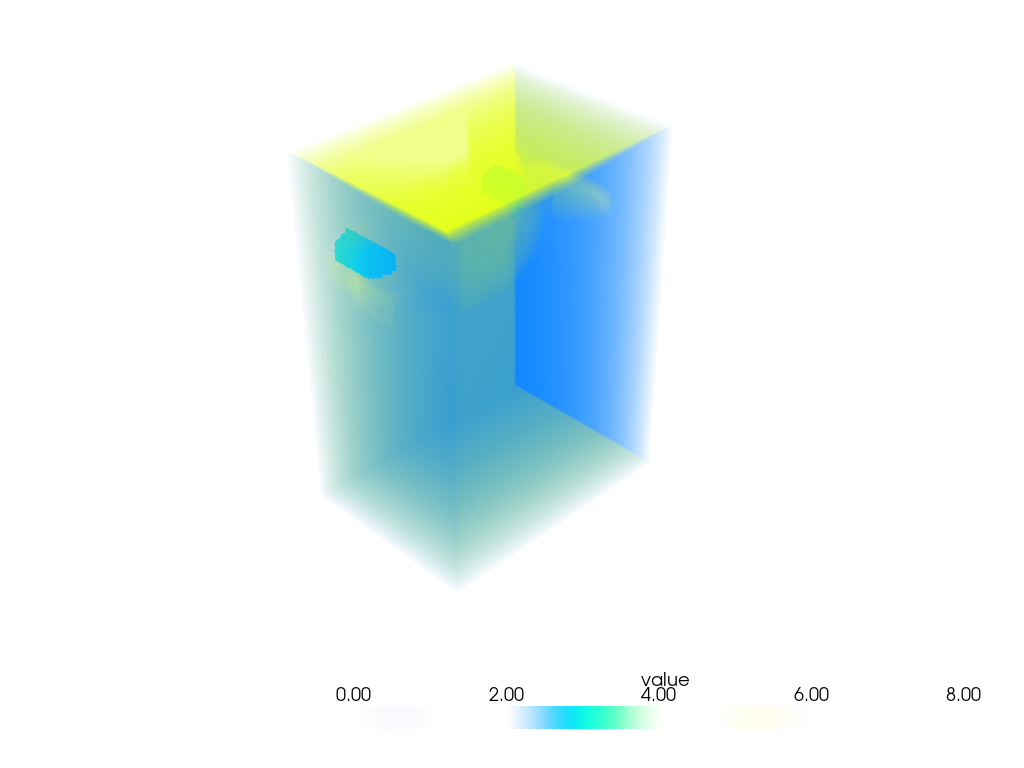

In [34]:
unique, counts = np.unique(region_mask, return_counts=True)

opacity = np.zeros(max(9, unique.max()))
opacity[unique] = np.minimum(20000 / counts, 1.0)
opacity[0] = 0

p = project.visual.pyvista.plot_volume(region_mask, affine, cmap='jet', clim=(0, 8), opacity=opacity)
p.show(jupyter_backend='static')

# Generate volume mesh from region mask

In [36]:
project.preprocessing.api.create_volume_mesh_from_mask(
    mask_path=ex.paths['region_mask'],
    output_path=ex.paths['volume_mesh'],
    use_affine_spacing=False,
    pygalmesh_kws=dict(
        max_facet_distance=0.75,
        max_cell_circumradius=5.0,
        odt=True, lloyd=True,
    )
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz
Generating volume mesh from mask
Removed 0 unreferenced point(s)
Mesh has 1 connected component(s)
<meshio mesh object>
  Number of points: 6778
  Number of cells:
    triangle: 16854
    tetra: 32103
  Point data: medit:ref
  Cell data: label
Saving ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Done


In [37]:
vol_mesh = project.core.fileio.load_meshio(ex.paths['volume_mesh'])

p = project.visual.pyvista.plot_mesh(vol_mesh, scalar='label', cmap='jet', clim=(0, 8), opacity=1.0)
p.show(jupyter_backend='trame')

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14c170e2d210_14" src="https://ondemand.bridges2.…

# Assign materials and properties

In [38]:
project.preprocessing.api.create_material_fields(
    mask_path=ex.paths['region_mask'],
    density_path=ex.paths['density_field'],
    elastic_path=ex.paths['elastic_field'],
    output_path=ex.paths['material_mask']
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz
Assigning material properties to regions
  density_key  density_val  density_freq elastic_key  elastic_val  \
0         0.0          0.0          0.00         0.0          0.0   
1       Dense        500.0          0.75        Hard       9000.0   
2       Dense        500.0          0.75      Medium       3000.0   
3       Dense        500.0          0.75        Soft       1000.0   
4      Porous         50.0          0.25        Hard       9000.0   
5      Porous         50.0          0.25      Medium       3000.0   
6      Porous         50.0          0.25        Soft       1000.0   

   elastic_freq  material_key  material_freq  poisson_ratio  
0          0.00    Background         0.0000            0.0  
1          0.25     DenseHard         0.1875            0.4  
2          0.50   DenseMedium         0.3750            0.4  
3          0.25     DenseSoft         0.1875            0.4  
4     

# Forward FEM simulation

In [79]:
%autoreload
project.preprocessing.api.simulate_displacement_field(
    mesh_path=ex.paths['volume_mesh'],
    density_path=ex.paths['density_field'],
    elastic_path=ex.paths['elastic_field'],
    nodes_path=ex.paths['node_values'],
    output_path=ex.paths['disp_field'],
    unit_m=float(ex.metadata['unit'])
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz
Simulating displacement using material fields
Interpolating material fields onto mesh nodes
Initializing finite element solver
Assembling load vector
Assembling stiffness matrix
Applying boundary conditions
Solving forward system
Rasterizing output field
(128, 128, 128, 3) float32
E (6778, 1) float32
mu (6778, 1) float32
lam (6778, 1) float32
rho (6778, 1) float32
bc (6778, 3) float32
u (6778, 3) float32
Saving ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/node_values.xdmf
Saving ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/displacement.nii.gz


In [80]:
nifti = project.core.fileio.load_nibabel(ex.paths['region_mask'])
nifti

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz


In [81]:
mesh = project.core.fileio.load_meshio(ex.paths['node_values'])
mesh

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/node_values.xdmf


<meshio mesh object>
  Number of points: 6778
  Number of cells:
    tetra: 32103
  Point data: E, mu, lam, rho, bc, u
  Cell data: label

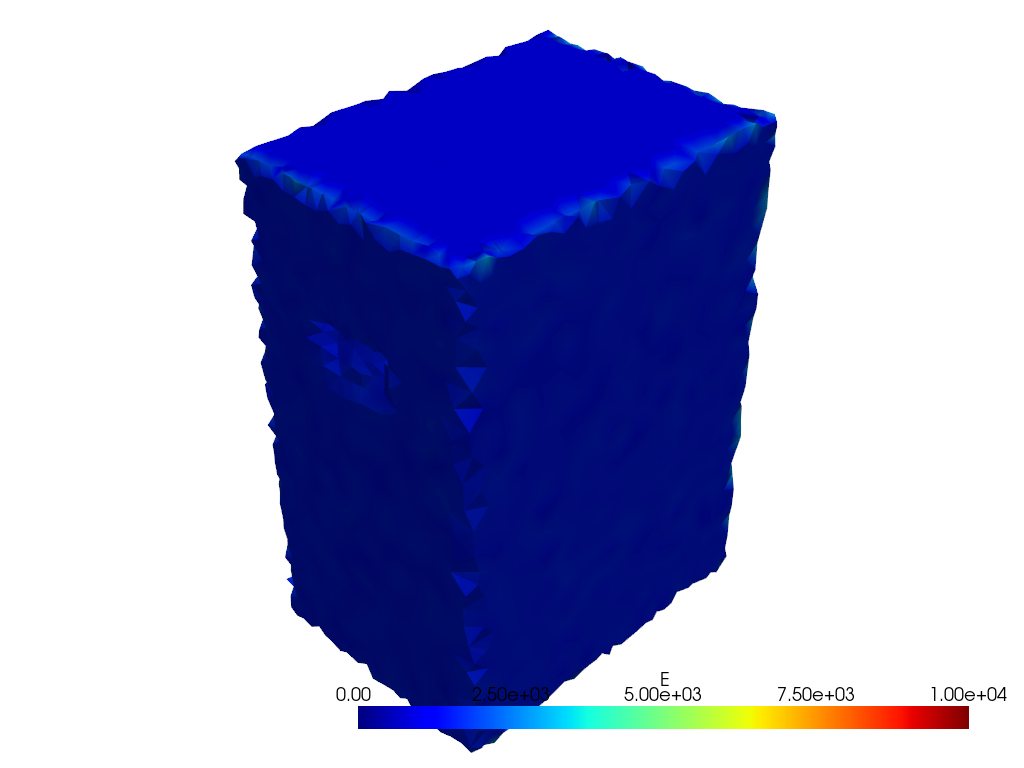

In [83]:
p = project.visual.pyvista.plot_mesh(mesh, scalar='E', cmap='jet', clim=(0, 1e4))
p.show(jupyter_backend='static')

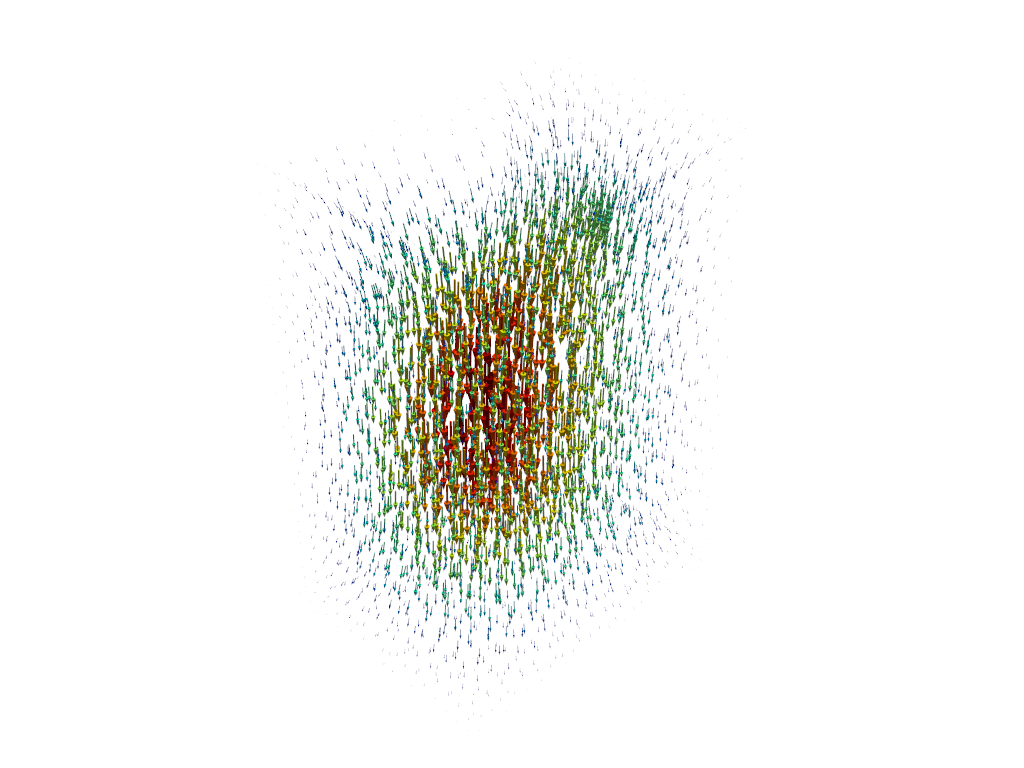

In [100]:
p = pv.Plotter()
m = pv.wrap(mesh)
p.add_mesh(m.glyph(scale='u', orient='u'), cmap='jet', show_scalar_bar=False)
p.show(jupyter_backend='static')

In [101]:
float(ex.metadata['unit'])

0.0136197560186615

# Texture annotations

In [15]:
import os
tex = pd.read_csv('texture_annotations_2025-10-21.csv')
tex.path = tex.path.map(os.path.abspath)

# manual corrections/additional annotations
tex.loc[[1, 76, 42], 'annotation'] = 'marble'
tex.loc[88, 'annotation'] = 'brick'
tex.loc[80, 'annotation'] = 'stone'
tex.loc[ 8, 'annotation'] = 'fiberboard'
tex.loc[[84, 90], 'annotation'] = 'grass'
tex.loc[97, 'annotation'] = 'stone'
tex.loc[ 3, 'annotation'] = 'cardboard'
tex.loc[[27, 72, 54, 89, 74, 73], 'annotation'] = 'paper'
tex.loc[[74, 100], 'annotation'] = 'fabric'
tex.loc[[34], 'annotation'] = 'stone'
tex.loc[[98, 103], 'annotation'] = 'gravel'
tex.loc[[56], 'annotation'] = 'paint'
tex.loc[[101], 'annotation'] = 'paper'

tex.loc[:, 'is_texture'] = True
tex.loc[[32, 82, 13, 41, 113, 33, 87, 7, 28, 20, 56, 3, 77], 'is_texture'] = False

tex.loc[:, 'is_duplicate'] = False
tex.loc[[10, 12, 29, 40, 57, 60, 61, 71, 95, 80, 51, 22, 105, 59, 94, 68, 69, 109, 110, 4, 23, 24, 36, 43, 47, 62, 79, 18, 26, 76, 90, 106, 38], 'is_duplicate'] = True

tex.loc[:, 'poor_quality'] = False
tex.loc[[5, 45, 17, 48, 67, 92, 83, 81, 53, 2, 16, 39, 88, 49, 21], 'poor_quality'] = True

tex.loc[:, 'bad_shape'] = False
tex.loc[[73, 89, 75, 97, 85, 19, 107, 100, 111], 'bad_shape'] = True

tex.loc[:, 'inverted'] = False
tex.loc[[55], 'inverted'] = True
tex

,idx,path,annotation,is_texture,is_duplicate,poor_quality,bad_shape,inverted
0,18231,/ocean/projects/asc170022p/mtragoza/lung-proje...,carpet,True,False,False,False,False
1,17033,/ocean/projects/asc170022p/mtragoza/lung-proje...,marble,True,False,False,False,False
2,18752,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,False,True,False,False
3,17435,/ocean/projects/asc170022p/mtragoza/lung-proje...,cardboard,False,False,False,False,False
4,3048,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,True,False,False,False
...,...,...,...,...,...,...,...,...
109,42,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,True,False,False,False
110,12807,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,True,False,False,False
111,5066,/ocean/projects/asc170022p/mtragoza/lung-proje...,wood,True,False,False,True,False
112,5531,/ocean/projects/asc170022p/mtragoza/lung-proje...,leather,True,False,False,False,False


In [16]:
texture_type_to_material = {
    'paper':   'DenseSoft',
    'leather': 'DenseMedium',
    'stone':   'DenseHard',
    'fabric':  'PorousSoft',
    'wood':    'PorousMedium',
    'marble':  'PorousHard'
}
is_valid = tex.is_texture & ~(tex.is_duplicate | tex.poor_quality | tex.bad_shape)
tex.loc[is_valid, 'material'] = tex.annotation.map(texture_type_to_material)
tex.groupby('material').count()

,idx,path,annotation,is_texture,is_duplicate,poor_quality,bad_shape,inverted
material,,,,,,,,
DenseHard,3,3,3,3,3,3,3,3
DenseMedium,4,4,4,4,4,4,4,4
DenseSoft,4,4,4,4,4,4,4,4
PorousHard,3,3,3,3,3,3,3,3
PorousMedium,4,4,4,4,4,4,4,4
PorousSoft,4,4,4,4,4,4,4,4


In [17]:
#tex.to_csv(ds.root / 'texture_annotations_2025-10-25.csv', index=False)

# Image generation

In [22]:
%autoreload
import project.preprocessing.texturing

project.preprocessing.api.generate_volumetric_image(
    mask_path=ex.paths['material_mask'],
    output_path=ex.paths['input_image'],
    annots_path=ds.root / 'texture_annotations_2025-10-25.csv'
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/material.nii.gz
Building texture cache
Generating textured volumetric image
list(len=3)
├── 0: ndarray(shape=(512, 512), dtype=float64)
|   ├── 0: ndarray(shape=(512,), dtype=float64)
|   ├── 1: ndarray(shape=(512,), dtype=float64)
|   ├── 2: ndarray(shape=(512,), dtype=float64)
|   ├── 3: ndarray(shape=(512,), dtype=float64)
|   ├── 4: ndarray(shape=(512,), dtype=float64)
|   ├── 5: ndarray(shape=(512,), dtype=float64)
|   ├── 6: ndarray(shape=(512,), dtype=float64)
|   ├── 7: ndarray(shape=(512,), dtype=float64)
|   ├── 8: ndarray(shape=(512,), dtype=float64)
|   ├── 9: ndarray(shape=(512,), dtype=float64)
|   └── <502 more items>
├── 1: ndarray(shape=(512, 512), dtype=float64)
|   ├── 0: ndarray(shape=(512,), dtype=float64)
|   ├── 1: ndarray(shape=(512,), dtype=float64)
|   ├── 2: ndarray(shape=(512,), dtype=float64)
|   ├── 3: ndarray(shape=(512,), dtype=float64)
|   ├── 4: ndarray(shape=(512,), dtype=float

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/images/generated.nii.gz


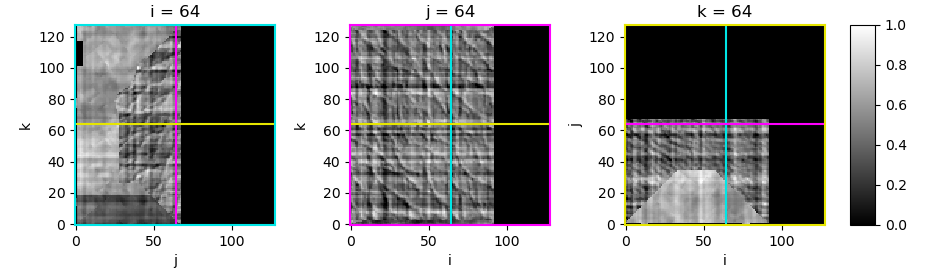

In [26]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['input_image'])
image = nifti.get_fdata()

fig = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0, 1), colors='cmy')

In [71]:
class SIREN(torch.nn.Module):
    def __init__(self, n_input=3, n_output=1, n_hidden=128):
        super().__init__()
        self.l1 = torch.nn.Linear(n_input, n_hidden)
        self.l2 = torch.nn.Linear(n_hidden, n_hidden)
        self.l3 = torch.nn.Linear(n_hidden, n_hidden)
        self.l4 = torch.nn.Linear(n_hidden, n_hidden)
        self.l5 = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.sin(self.l1(x))
        x = torch.sin(self.l2(x))
        x = torch.sin(self.l3(x))
        x = torch.sin(self.l4(x))
        return self.l5(x)

    def init_weights(self, w0=30, c=6):
        for i, m in enumerate(self.children()):
            fan_in = m.weight.shape[-1]
            scale = w0 / fan_in if i == 0 else -np.sqrt(c / fan_in)
            m.weight.uniform_(-scale, scale)

model = SIREN()
model

SIREN(
  (l1): Linear(in_features=3, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=128, bias=True)
  (l5): Linear(in_features=128, out_features=1, bias=True)
)

In [81]:
texture = texture_cache['DenseMedium']['../../data/ShapeNetSem/models-textures/textures/8a1b661a4dd6aa56.jpg']
pprint(texture, 0)

ndarray(shape=(400, 400), dtype=float64)


In [87]:
texture.shape

(400, 400)

In [99]:
class SliceDataset(torch.utils.data.Dataset):
    def __init__(self, dim_size, dtype=torch.float32, device='cuda'):
        coords = torch.linspace(-1, 1, dim_size, dtype=dtype, device=device)
        self.U, self.V = torch.meshgrid(coords, coords, indexing='ij')
        self.slices = []
        for slice_dim in range(3):
            for slice_coord in coords:
                self.slices.append([slice_dim, slice_coord])

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        slice_dim, slice_coord = self.slices[idx]
        slice_coord = torch.full_like(self.U, slice_coord)
        if slice_dim == 0:
            points = torch.stack([slice_coord, self.U, self.V], dim=-1)
        elif slice_dim == 1:
            points = torch.stack([self.U, slice_coord, self.V], dim=-1)
        elif slice_dim == 2:
            points = torch.stack([self.U, self.V, slice_coord], dim=-1)
        return points.reshape(-1, 3)

data = SliceDataset(dim_size=128)
len(data)

384

In [100]:
def train(model, data, batch_size=1, lr=1e-4):
    optim = torch.optim.Adam([model.parameters()], lr=lr)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)
    for i, points in enumerate(data_loader):
        print(points.shape, flush=True)

train(model, data)

AttributeError: module 'triton.language' has no attribute 'core'

# Signed distance functions

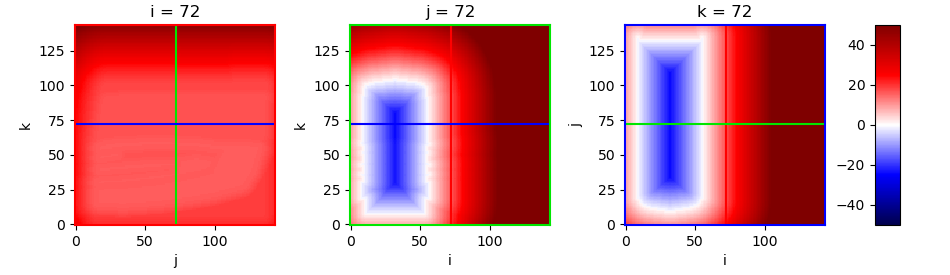

In [50]:
import scipy
def convert_binary_mask_to_sdf(input_mask):
    a = (input_mask != 0)
    d_out = scipy.ndimage.distance_transform_edt(~a)
    d_in  = scipy.ndimage.distance_transform_edt(a)
    return d_out - d_in

sdf_array = convert_binary_mask_to_sdf(padded_array)

fig = project.visual.matplotlib.show_image_slices(sdf_array, cmap='seismic', clim=(-50, 50))

In [51]:
import skimage
def generate_surface_from_sdf(sdf_array, affine, step_size):
    v, f, n, _ = skimage.measure.marching_cubes(sdf_array, level=0, allow_degenerate=False, step_size=step_size)
    v = project.core.transforms.voxel_to_world_coords(v, affine)
    return v, f

v, f = generate_surface_from_sdf(sdf_array, padded_affine, step_size=2)
sdf_mesh = trimesh.Trimesh(vertices=v, faces=f, process=False)
sdf_mesh.is_watertight

True

In [52]:
p = pv.Plotter()
p.add_mesh(pv.wrap(sdf_mesh), color='blue', opacity=0.5, show_edges=True)
p.enable_depth_peeling(10)
p.show(jupyter_backend='trame')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14bed798df90_10" src="https://ondemand.bridges2.…

In [339]:
labels, counts = np.unique(output_array, return_counts=True)
pprint(counts)

opacity = np.zeros(9, dtype=float)
opacity[labels] = np.minimum(25000 / counts, 1.0)
opacity[0] = 0
pprint(opacity)

ndarray(shape=(4,), dtype=int64)
├── 0: np.int64(1567366)
├── 1: np.int64(95970)
├── 2: np.int64(212257)
└── 3: np.int64(221559)
ndarray(shape=(9,), dtype=float64)
├── 0: np.float64(0.0)
├── 1: np.float64(0.26049807231426486)
├── 2: np.float64(0.11778174571392228)
├── 3: np.float64(0.11283676131414205)
├── 4: np.float64(0.0)
├── 5: np.float64(0.0)
├── 6: np.float64(0.0)
├── 7: np.float64(0.0)
└── 8: np.float64(0.0)


In [341]:
pv_grid = pv.ImageData(
    dimensions=bin_array.shape,
    spacing=np.linalg.norm(affine[:3,:3], axis=1),
    origin=affine[:3,3]
)
pv_grid.point_data['mask'] = bin_array.flatten(order='F').astype(int)
pv_grid.point_data['label'] = output_array.flatten(order='F').astype(int)

p = pv.Plotter()
p.add_volume(
    pv_grid,
    scalars='label',
    cmap='jet',
    clim=(0, 8),
    opacity=opacity
)
p.enable_depth_peeling(10)
p.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x154c39c22c10_72" src="https://ondemand.bridges2.…